# Project Overview

Tanzania, as a developing country, struggles with providing clean water to its population of over 57,000,000. There are many waterpoints already established in the country, but some are in need of repair while others have failed altogether.

Can you predict which water pumps are faulty?

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

Build a classifier to predict the condition of a water well, using information about the sort of pump, when it was installed, etc. Note that this is a ternary classification problem.

<a href="https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/">Tanzanian Water Well Data</a>
 
This dataset is part of an active competition until April 31, 2021!



## Import packages

In [102]:
import pandas as pd
import numpy as np
import sys
import zipfile
import folium
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ParameterGrid
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from mlxtend.classifier import StackingClassifier

## Data

#### Import Data

In [103]:
X = pd.read_csv("../../references/training_set_values.csv", index_col = 'id')

In [104]:
y = pd.read_csv("../../references/training_set_labels.csv", index_col = 'id')['status_group']

In [105]:
unlabeled_df = pd.read_csv("../../references/test_set_values.csv", index_col = 'id')

#### Feature info

<a href="https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/">Link to information about features</a>

In [106]:
# amount_tsh - Total static head (amount water available to waterpoint)
# date_recorded - The date the row was entered - do not include
# funder - Who funded the well
# gps_height - Altitude of the well
# installer - Organization that installed the well
# longitude - GPS coordinate - do not include
# latitude - GPS coordinate - do not include
# wpt_name - Name of the waterpoint if there is one
# num_private -
# basin - Geographic water basin
# subvillage - Geographic location
# region - Geographic location
# region_code - Geographic location (coded)
# district_code - Geographic location (coded)
# lga - Geographic location
# ward - Geographic location
# population - Population around the well
# public_meeting - True/False - ?
# recorded_by - Group entering this row of data
# scheme_management - Who operates the waterpoint
# scheme_name - Who operates the waterpoint
# permit - If the waterpoint is permitted
# construction_year - Year the waterpoint was constructed
# extraction_type - The kind of extraction the waterpoint uses
# extraction_type_group - The kind of extraction the waterpoint uses
# extraction_type_class - The kind of extraction the waterpoint uses
# management - How the waterpoint is managed
# management_group - How the waterpoint is managed
# payment - What the water costs
# payment_type - What the water costs
# water_quality - The quality of the water
# quality_group - The quality of the water
# quantity - The quantity of water
# quantity_group - The quantity of water
# source - The source of the water
# source_type - The source of the water
# source_class - The source of the water
# waterpoint_type - The kind of waterpoint
# waterpoint_type_group - The kind of waterpoint

### Maps

#### Scatter Plot of Wells

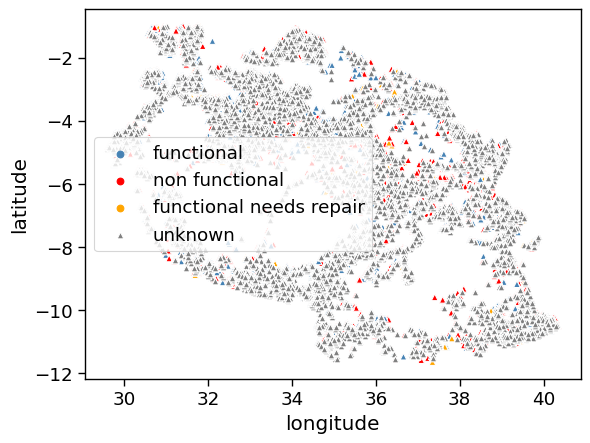

In [107]:
df_loc = X.join(y)[['longitude', 'latitude', 'status_group']]
df_loc = df_loc[df_loc['longitude']!=0]
df_loc.status_group.value_counts()

sns.scatterplot(data=df_loc, x = 'longitude', y = 'latitude', marker = '^', alpha = 1,
                hue = df_loc.status_group.tolist(), palette = ['steelblue', 'red', 'orange'])


test_df_loc = unlabeled_df[['longitude', 'latitude']]
test_df_loc = test_df_loc[test_df_loc['longitude']!=0]
test_df_loc['status_group'] = 'unknown'
sns.scatterplot(data = test_df_loc, x = 'longitude', y = 'latitude', marker= "^", color = 'grey', label = 'unknown');

#### Import shape files for Tanzania

In [108]:
# Uncomment to download shapefiles
# ! wget -P ../../data http://stacks.stanford.edu/file/druid:tn398yw9512/data.zip

In [109]:
# Uncomment to unzip shapefiles
# with zipfile.ZipFile('../../data/data.zip', 'r') as zip_ref:
#     zip_ref.extractall('../../data/shapefiles')

#### Create GeoDataFrames from Data
Convert crs from 4326 to 3857 (changes latitude and logitude format for plotting)

In [110]:
geo_df = gpd.read_file('../../data/shapefiles/TAN.shp')
geo_df = geo_df.to_crs(epsg = 3857)

C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [111]:
# Add a geometry column that holds Point objects with lat and long
df_loc['geometry'] = df_loc.apply(lambda x: Point(float(x.longitude), float(x.latitude)), axis=1)
gdf = gpd.GeoDataFrame(df_loc, geometry='geometry')
gdf.crs = "EPSG:4326"
gdf = gdf.to_crs(epsg = 3857)

C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [112]:
# Add a geometry column that holds Point objects with lat and long
test_df_loc['geometry'] = test_df_loc.apply(lambda x: Point(float(x.longitude), float(x.latitude)), axis=1)
gdf_test = gpd.GeoDataFrame(test_df_loc, geometry='geometry')
gdf_test.crs = "EPSG:4326"
gdf_test = gdf_test.to_crs(epsg = 3857)

C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


#### Create Folium map to show where Tanzania is

In [113]:
m = folium.Map(location=[-6.3690, 34.8888], zoom_start = 5)
m.choropleth(geo_data=geo_df, fill_color='blue', fill_opacity=0.2, line_opacity=.1)
display(m)

C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


#### Geopandas plots with Contextly

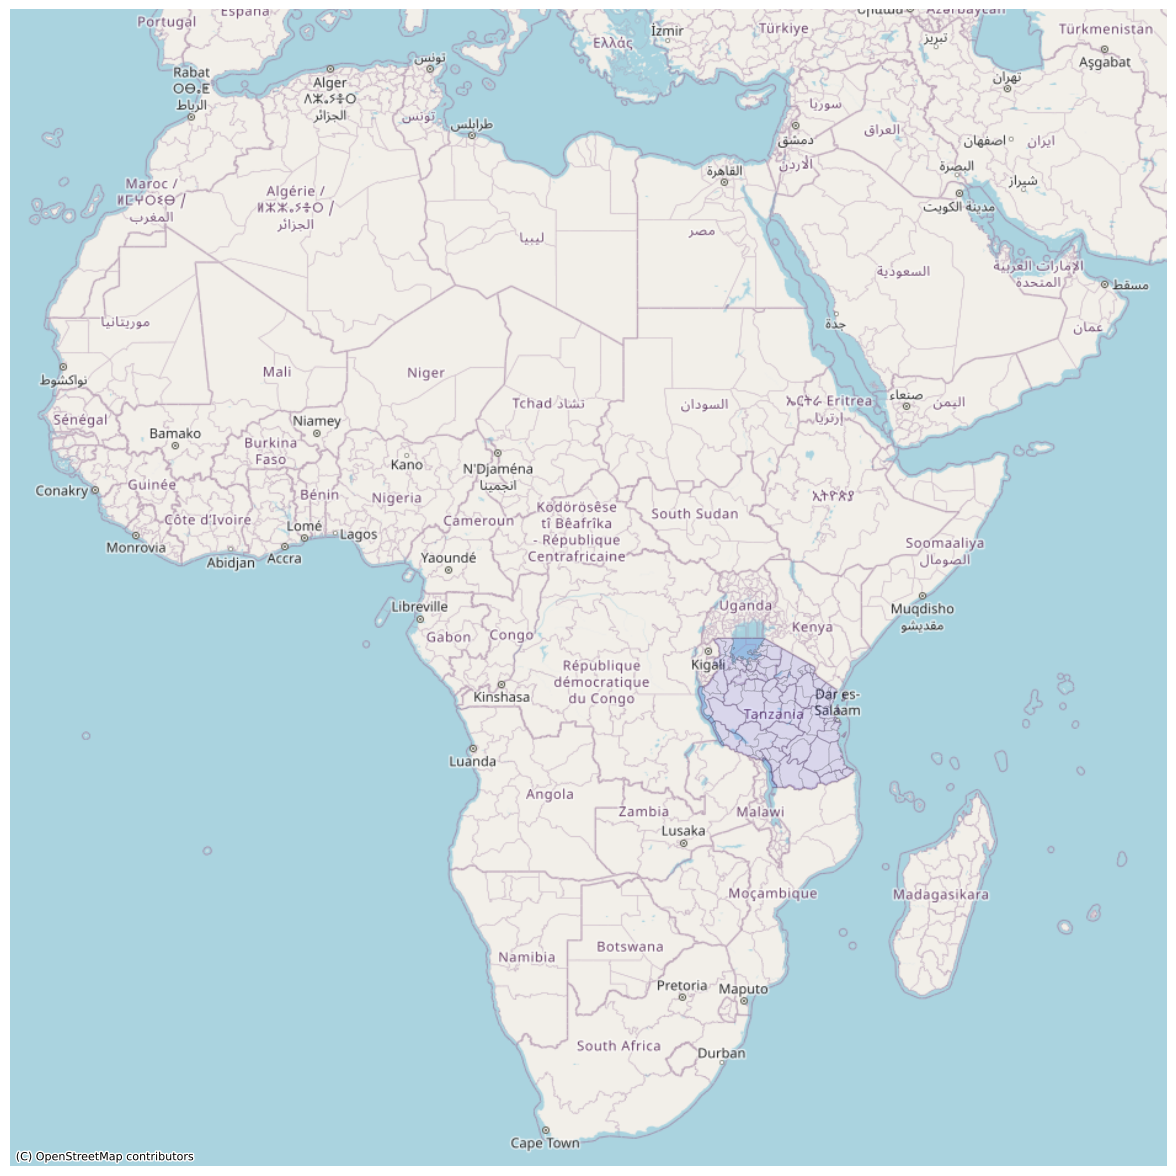

In [114]:
plt.style.use('default')
sns.set_context("paper", font_scale=1.5)

fig, ax = plt.subplots(figsize=(12,12))
geo_df.plot(ax=ax, color = 'blue', edgecolor = 'k', alpha = .1)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-5500000, maxx+2500000)
ax.set_ylim(miny-3000000, maxy+5000000)

ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik) #source=ctx.providers.OpenStreetMap.Mapnik) lots of styles to choose from
# plt.title('Tanzanian Water Wells')

ax.set_axis_off()
fig.tight_layout()
plt.savefig('../../reports/figures/Africa.jpg');

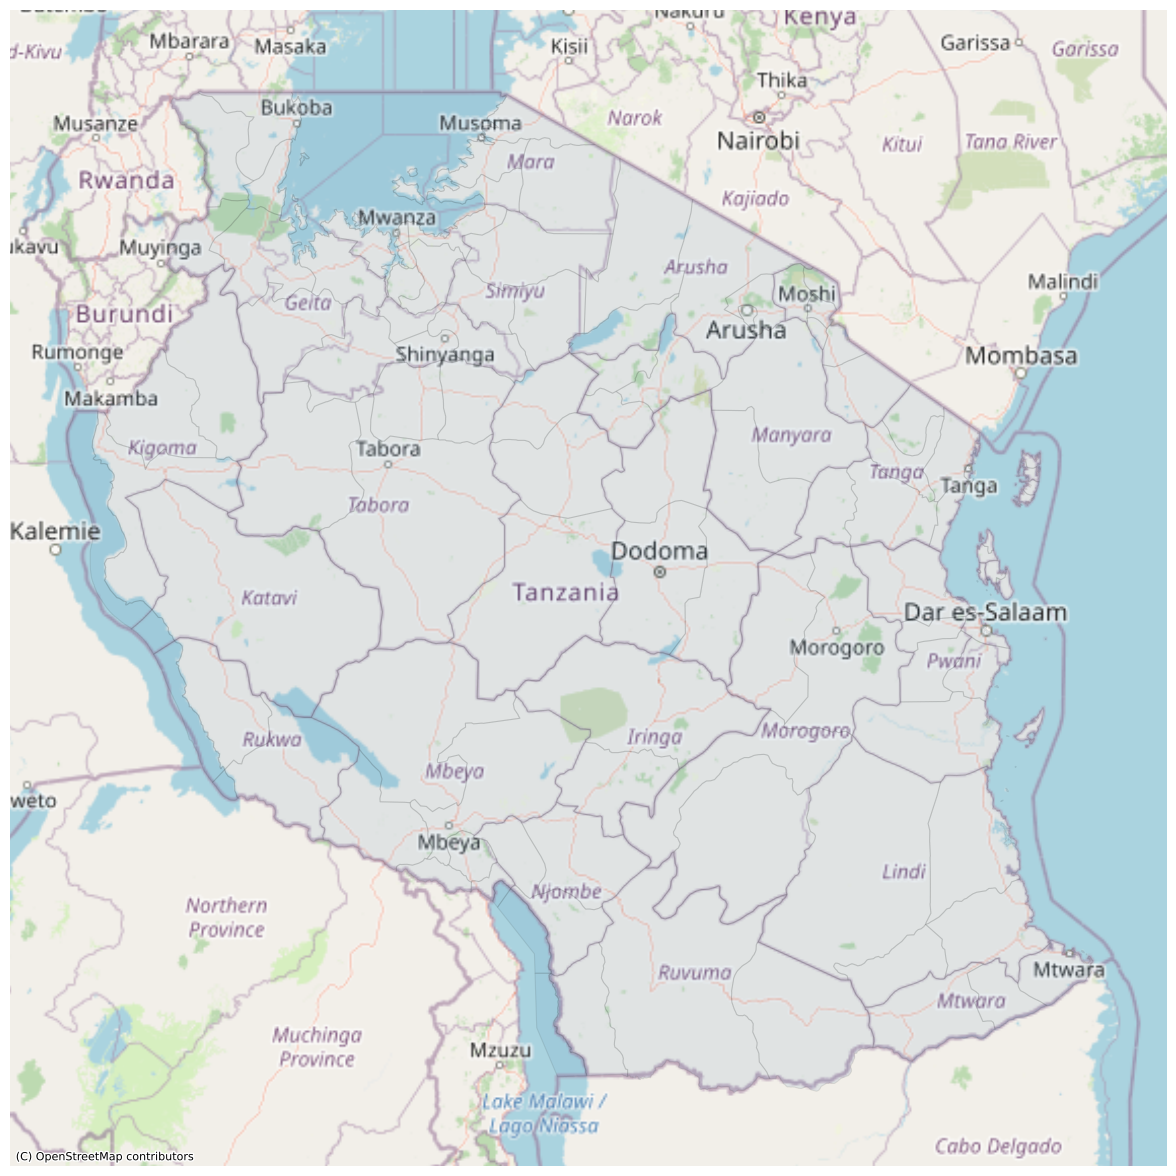

In [322]:
plt.style.use('default')
sns.set_context("paper", font_scale=1.5)

fig, ax = plt.subplots(figsize=(12,12))
geo_df.plot(ax=ax, color = 'steelblue', edgecolor = 'k', alpha = .1)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-100000, maxx+100000)
ax.set_ylim(miny-100000, maxy+100000)

ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik) #source=ctx.providers.OpenStreetMap.Mapnik) lots of styles to choose from
# plt.title('Tanzania', fontdict={'fontsize': '50', 'fontweight' : '10', 'color' : 'coral'})

ax.set_axis_off()
fig.tight_layout()
plt.savefig('../../reports/figures/Tanzania.jpg', dpi = 300);

#### Add Wells + Status to Plot

ValueError: [(0.30196078431372547, 0.7137254901960784, 0.6745098039215687), (0.0, 0.0, 0.0), (0.9568627450980393, 0.5137254901960784, 0.1568627450980392)] is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

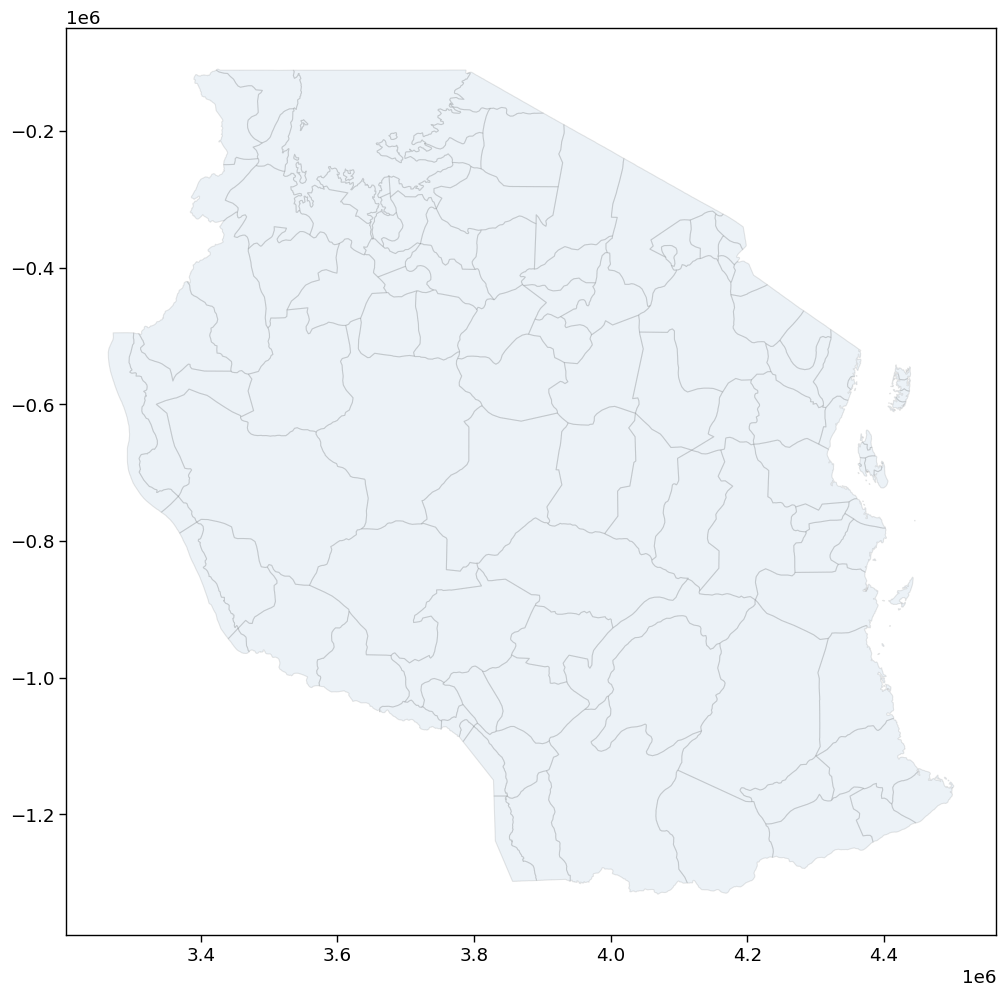

In [336]:
sns.set_context(font_scale=2)

fig, ax = plt.subplots(figsize=(12,12))

geo_df.plot(ax=ax, color = 'steelblue', edgecolor = 'k', alpha = .1)

colors = ["#4DB6AC", "black", "#F48328"]
customPalette = sns.color_palette(colors)

gdf.plot(ax=ax, column = 'status_group', marker = '.', markersize=200,
         edgecolor = 'white', cmap = customPalette,
         linewidth=1, legend = True)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-100000, maxx+100000)
ax.set_ylim(miny-100000, maxy+100000)

ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik)#, source=ctx.providers.OpenStreetMap.Mapnik)
# plt.title('Tanzanian Water Wells', fontdict={'fontsize': '50', 'fontweight' : '10', 'color' : 'coral'})

ax.set_axis_off()
fig.tight_layout()
plt.savefig('../../reports/figures/Tanzania_train.jpg', dpi = 300);

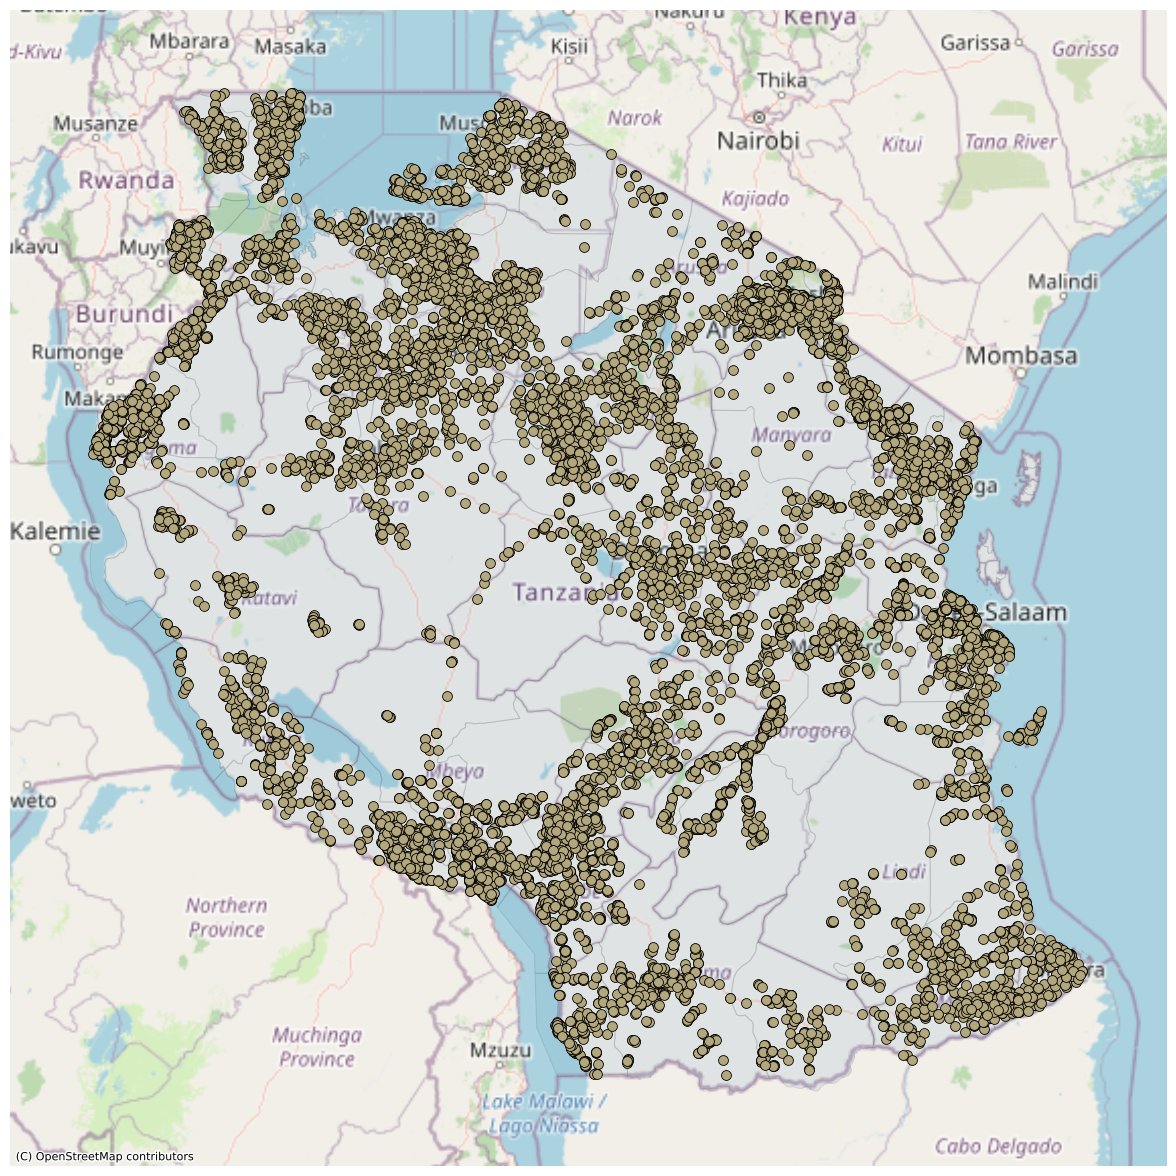

In [331]:
fig, ax = plt.subplots(figsize=(12,12))
geo_df.plot(ax=ax, color = 'steelblue', edgecolor = 'k', alpha = .1)

gdf_test.plot(ax=ax, marker = '.', markersize=200, color='#B3A77D',
              edgecolor = 'black', linewidth=.6, legend = True)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-100000, maxx+100000)
ax.set_ylim(miny-100000, maxy+100000)

ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik)#, source=ctx.providers.OpenStreetMap.Mapnik)
# plt.title('Tanzanian Water Wells', fontdict={'fontsize': '50', 'fontweight' : '10', 'color' : 'coral'})
ax.set_axis_off()
fig.tight_layout()
plt.savefig('../../reports/figures/Tanzania_test.jpg', dpi = 300);

### Data Cleaning

#### Drop Date and NA and unique identifier columns for now

In [118]:
# X.info()

In [119]:
columns_with_na = ['permit', 'scheme_name', 'scheme_management', 'public_meeting', 'subvillage', 'installer', 'funder']
X.drop(columns_with_na, axis=1, inplace=True)

In [120]:
columns_with_specific_location_and_names = ['ward', 'wpt_name']
X.drop(columns_with_specific_location_and_names, axis=1, inplace=True)

In [121]:
X.drop('date_recorded', axis=1, inplace=True)

### EDA Visuals

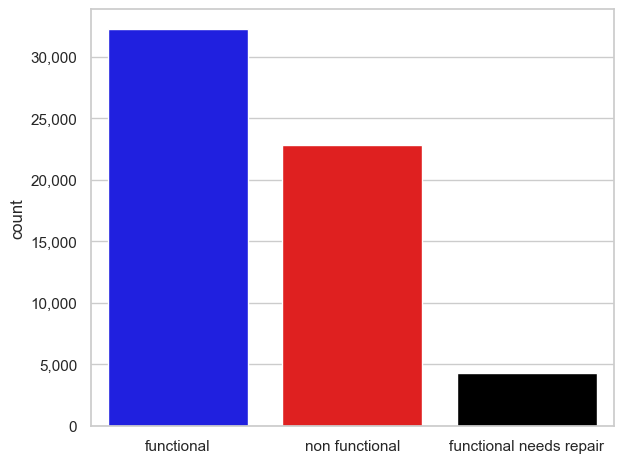

In [302]:
plt.style.use('default')
sns.set(context = 'notebook', style = 'whitegrid')
colors = ["blue", "red", "black"]

my_palette = sns.color_palette(colors)

fig, ax = plt.subplots() 
# ax.yaxis.grid(alpha=.25) # horizontal lines

# ax.hist(y, bins = 5)
# ax.set_title('Well Status Distribution', fontdict={'fontsize': '25', 'fontweight' : '30', 'color' : 'black'})

sns.countplot(y, palette=my_palette)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set(xlabel=None)
fig.tight_layout()
plt.savefig('../../reports/figures/Well_status_dist.jpg')

## Preprocess Data for Model

#### Train Test Split

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 42)

#### Split Data into continuous and categorical

In [124]:
X.dtypes.value_counts()

object     20
int64       6
float64     3
dtype: int64

In [125]:
X_train_cat = X_train.select_dtypes(include='object')
X_train_cont = X_train.select_dtypes(exclude='object')
X_test_cat = X_test.select_dtypes(include='object')
X_test_cont = X_test.select_dtypes(exclude='object')

#### Simple Imputer to fill null numeric values

In [126]:
si = SimpleImputer()
X_train_imp = pd.DataFrame(si.fit_transform(X_train_cont), index = X_train_cont.index, columns = X_train_cont.columns)
X_test_imp = pd.DataFrame(si.transform(X_test_cont), index = X_test_cont.index, columns = X_test_cont.columns)

#### Standard Scaler to scale numeric values

In [127]:
ss = StandardScaler()
X_train_sc = pd.DataFrame(ss.fit_transform(X_train_imp), index = X_train_imp.index, columns = X_train_imp.columns)
X_test_sc = pd.DataFrame(ss.transform(X_test_imp), index = X_test_imp.index, columns = X_test_imp.columns)

#### OneHotEncoder for categorical columns

In [128]:
# X_train_cat.info()

In [129]:
ohe = OneHotEncoder(drop = 'if_binary', sparse = False)
X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train_cat),
                          columns = ohe.get_feature_names(X_train_cat.columns), index = X_train_cat.index)
X_test_ohe = pd.DataFrame(ohe.transform(X_test_cat),
                          columns = ohe.get_feature_names(X_test_cat.columns), index = X_test_cat.index)

#### Join numeric and object DataFrames back together after preprocessing

In [130]:
X_train_fin = X_train_sc.join(X_train_ohe)
X_test_fin = X_test_sc.join(X_test_ohe)
print('Features Count: ', X_train_fin.shape[1])

Features Count:  291


## Modeling

#### Create a Baseline Model

In [131]:
lr = LogisticRegression(max_iter=1000, random_state = 42)
lr.fit(X_train_fin, y_train)

LogisticRegression(max_iter=1000, random_state=42)

#### Score model on training data

In [132]:
# Score on our training data
y_pred = lr.predict(X_train_fin)
print(classification_report(y_train, y_pred)) 

                         precision    recall  f1-score   support

             functional       0.73      0.90      0.81     24161
functional needs repair       0.58      0.12      0.20      3243
         non functional       0.80      0.67      0.72     17146

               accuracy                           0.75     44550
              macro avg       0.70      0.56      0.58     44550
           weighted avg       0.75      0.75      0.73     44550



In [133]:
# Note - This cell takes time to run
# val = cross_val_score(lr, X_train_fin, y_train, cv=5)
# val

#### Score model on testing data

In [134]:
# Score on our testing data
y_pred = lr.predict(X_test_fin)
print(classification_report(y_test, y_pred)) 

                         precision    recall  f1-score   support

             functional       0.73      0.89      0.80      8098
functional needs repair       0.51      0.12      0.19      1074
         non functional       0.78      0.66      0.72      5678

               accuracy                           0.75     14850
              macro avg       0.68      0.56      0.57     14850
           weighted avg       0.74      0.75      0.73     14850



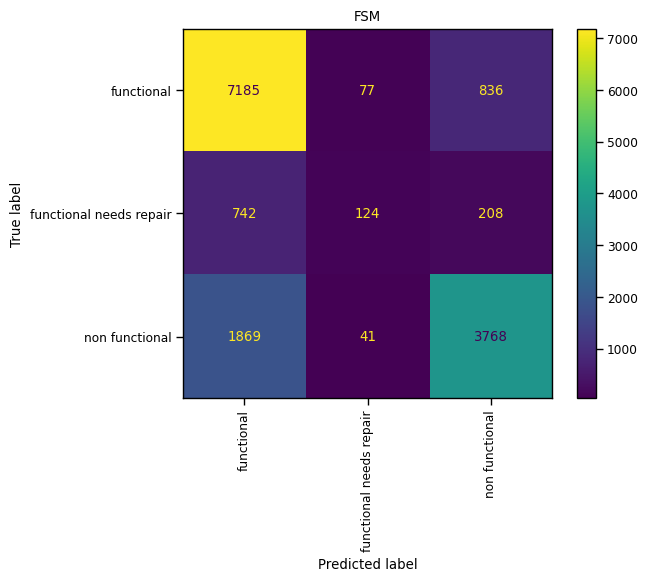

In [135]:
plot_confusion_matrix(lr, X_test_fin, y_test)
plt.title('FSM')
plt.xticks(rotation='vertical');

#### Coefficients of Features

In [136]:
coef = pd.DataFrame(lr.coef_, columns = X_test_fin.columns).transpose()

In [137]:
pd.set_option('display.max_rows', 500)
# coef

### Refining our Data

#### Using Smote to Deal with Class Imbalance

In [138]:
y_train.value_counts()

functional                 24161
non functional             17146
functional needs repair     3243
Name: status_group, dtype: int64

In [139]:
print("Before OverSampling, counts of label 'functional needs repair': {}".format(sum(y_train == 'functional needs repair'))) 
print("Before OverSampling, counts of label 'functional': {}".format(sum(y_train == 'functional'))) 
print("Before OverSampling, counts of label 'non functional': {} \n".format(sum(y_train == 'non functional'))) 
  
# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
sm = SMOTE(random_state = 42) 
X_train_res, y_train_res = sm.fit_sample(X_train_fin, y_train.ravel()) 

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 

print("After OverSampling, counts of label 'functional needs repair': {}".format(sum(y_train_res == 'functional needs repair'))) 
print("After OverSampling, counts of label 'functional': {}".format(sum(y_train_res == 'functional'))) 
print("After OverSampling, counts of label 'non functional': {}".format(sum(y_train_res == 'non functional')))

Before OverSampling, counts of label 'functional needs repair': 3243
Before OverSampling, counts of label 'functional': 24161
Before OverSampling, counts of label 'non functional': 17146 

After OverSampling, the shape of train_X: (72483, 291)
After OverSampling, the shape of train_y: (72483,) 

After OverSampling, counts of label 'functional needs repair': 24161
After OverSampling, counts of label 'functional': 24161
After OverSampling, counts of label 'non functional': 24161


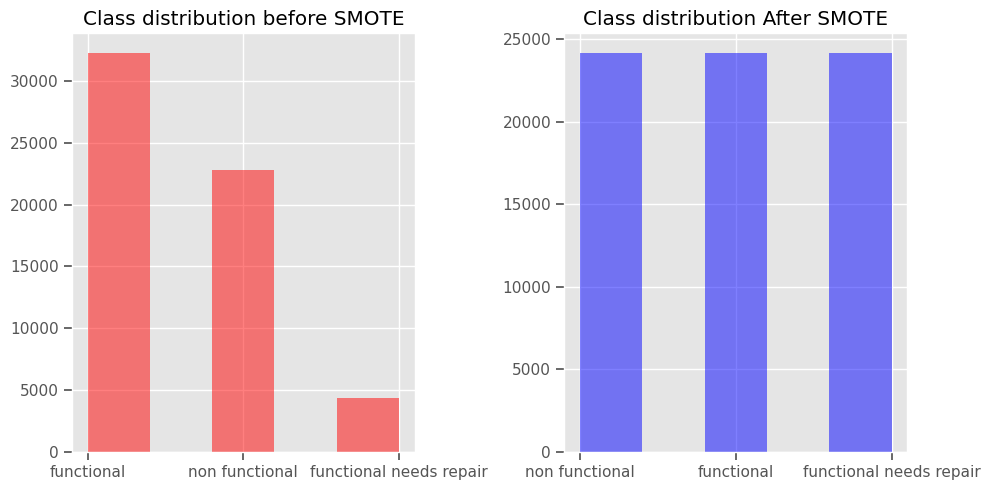

In [140]:
sns.set_context("notebook")
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5)) 
ax1.hist(y, color = 'red', alpha = .5, bins = 5)
ax1.set_title('Class distribution before SMOTE')
ax2.hist(y_train_res, color = 'blue', alpha = .5, bins = 5)
ax2.set_title('Class distribution After SMOTE')
fig.tight_layout();

#### Model After Smote

In [141]:
lr2 = LogisticRegression(max_iter=1000, random_state = 42)
lr2.fit(X_train_res, y_train_res)

LogisticRegression(max_iter=1000, random_state=42)

In [142]:
# Score on our training data
y_pred = lr2.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.65      0.64      0.65     24161
functional needs repair       0.65      0.74      0.69     24161
         non functional       0.76      0.66      0.70     24161

               accuracy                           0.68     72483
              macro avg       0.68      0.68      0.68     72483
           weighted avg       0.68      0.68      0.68     72483



In [143]:
# Score on our testing data
y_pred = lr2.predict(X_test_fin)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.63      0.70      8098
functional needs repair       0.21      0.72      0.32      1074
         non functional       0.77      0.65      0.70      5678

               accuracy                           0.64     14850
              macro avg       0.59      0.66      0.58     14850
           weighted avg       0.75      0.64      0.68     14850



Our accuracy is now more even across classes, especially on the training data. However on the testing data, while the recall score soared, the precision score plummeted? The f1 score is still not great on the testing data either but really improved on the training data for class "functional needs repair". Considering our model is working much better on our training data than our testing data, we could use regularization techniques to avoid overfitting.

#### Dealing with Multicollinearity
Some investigators use correlation coefficients cutoffs of 0.5 and above but most typical cutoff is 0.80

In [144]:
# heheX_train_res, y_train_res, X_test_fin, y_test

In [146]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(X_train_res, 50))

Top Absolute Correlations
management_unknown                  management_group_unknown                 1.000000
extraction_type_windmill            extraction_type_class_wind-powered       1.000000
extraction_type_gravity             extraction_type_group_gravity            1.000000
payment_other                       payment_type_other                       1.000000
extraction_type_gravity             extraction_type_class_gravity            1.000000
source_dam                          source_type_dam                          1.000000
extraction_type_other               extraction_type_class_other              1.000000
payment_never pay                   payment_type_never pay                   1.000000
source_type_other                   source_class_unknown                     1.000000
waterpoint_type_cattle trough       waterpoint_type_group_cattle trough      1.000000
extraction_type_windmill            extraction_type_group_wind-powered       1.000000
water_quality_coloured      

In [147]:
top_corrs = get_top_abs_correlations(X_train_res, 50) #Threshhold correlation for cut off at .97

In [148]:
features_to_drop = [pair[1] for pair in top_corrs.index]

In [149]:
len(features_to_drop)

50

In [150]:
# Remove Duplicates from list
features_to_drop = list(dict.fromkeys(features_to_drop))
len(features_to_drop)

45

In [151]:
X_train_res.shape

(72483, 291)

In [152]:
X_train_res.drop(features_to_drop, axis=1, inplace=True)

In [153]:
X_train_res.shape

(72483, 246)

In [154]:
X_test_fin.shape

(14850, 291)

In [155]:
X_test_fin.drop(features_to_drop, axis=1, inplace=True)

In [156]:
X_test_fin.shape

(14850, 246)

In [157]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(X_train_res, 3))

Top Absolute Correlations
water_quality_fluoride  quality_group_fluoride    0.970157
source_river            source_type_river/lake    0.967421
source_machine dbh      source_type_borehole      0.961588
dtype: float64


#### Feature Selection

In [158]:
#use inbuilt class feature_importances of tree based classifiers
model = ExtraTreesClassifier()
model.fit(X_train_res,y_train_res)

ExtraTreesClassifier()

In [159]:
# print(model.feature_importances_) 
feature_importance_df = pd.DataFrame(model.feature_importances_, index=X_train_res.columns).sort_values(by = 0, ascending = False)
feature_importance_df.head(10)

0
longitude              0.115725
latitude               0.114578
quantity_dry           0.056945
gps_height             0.053528
construction_year      0.043360
population             0.039420
quantity_enough        0.024779
quantity_insufficient  0.019638
extraction_type_other  0.017658
payment_never pay      0.017617

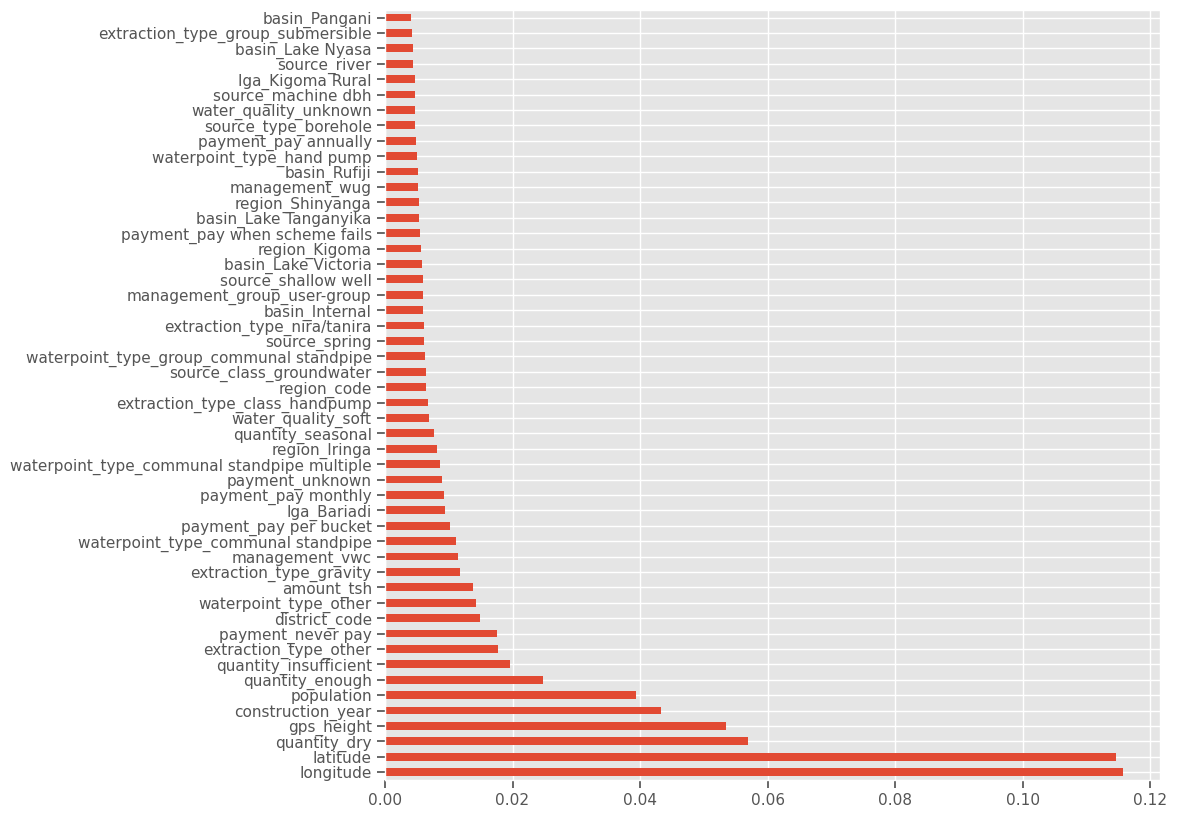

In [160]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train_res.columns)
fig = plt.subplots(figsize = (10,10))
feat_importances.nlargest(50).plot(kind='barh')
plt.show();

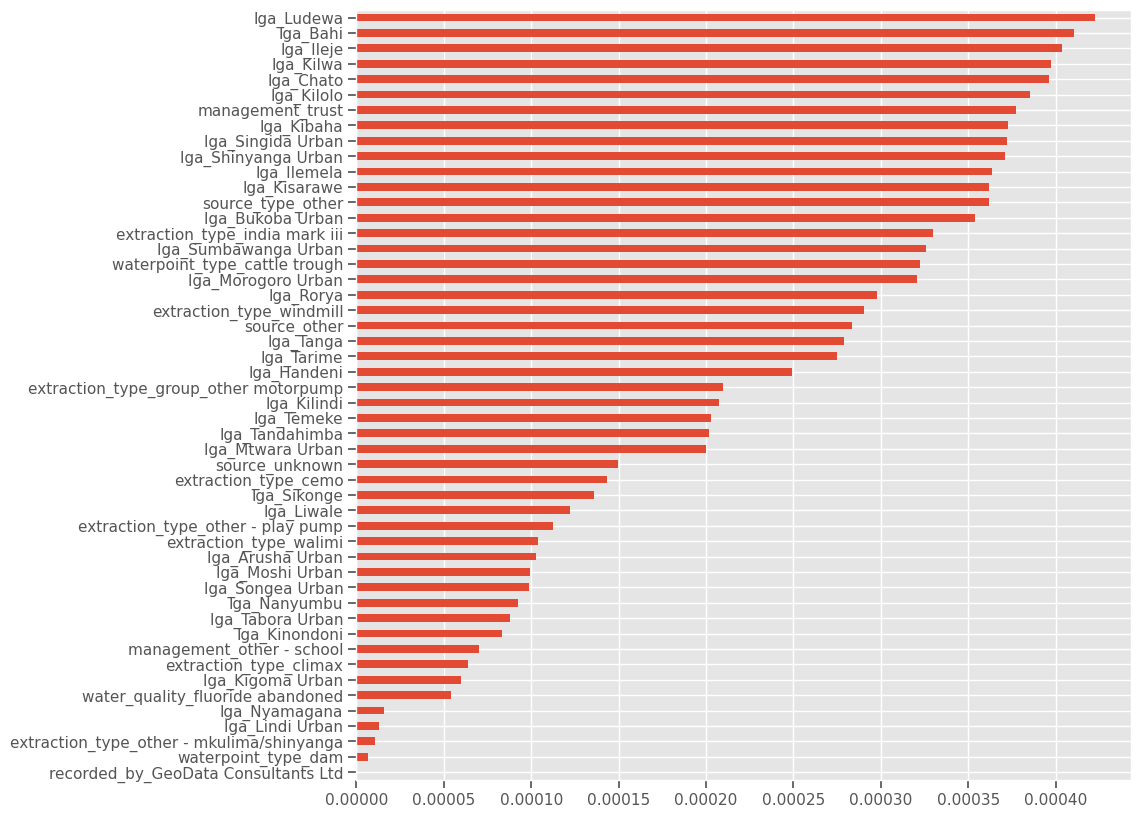

In [161]:
fig = plt.subplots(figsize = (10,10))
feat_importances.nsmallest(50).plot(kind='barh');


#### Filtered feature selection

In [162]:
print('Feature count: ', X_train_res.shape[1])

Feature count:  246


In [224]:
# Filter training and testing data with 246 largest features
X_train_filt = X_train_res[feat_importances.nlargest(246).index]
X_test_filt = X_test_fin[feat_importances.nlargest(246).index]

In [225]:
print('Feature count: ', X_train_filt.shape[1])

Feature count:  246


Model is working best when we use all the features

### Modeling with our Refined Data

Using hyperparameters from Andrew's tuning

In [226]:
# X_train_filt
# y_train_res
# X_test_filt
# y_test

#### Logistic Regression

In [227]:
lr3 = LogisticRegression(max_iter=1000, random_state = 42)
lr3.fit(X_train_filt, y_train_res)

LogisticRegression(max_iter=1000, random_state=42)

In [228]:
# Score on our training data
y_pred = lr3.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.65      0.64      0.65     24161
functional needs repair       0.65      0.74      0.69     24161
         non functional       0.76      0.66      0.70     24161

               accuracy                           0.68     72483
              macro avg       0.68      0.68      0.68     72483
           weighted avg       0.68      0.68      0.68     72483



In [229]:
# Score on our testing data
y_pred = lr3.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.63      0.70      8098
functional needs repair       0.20      0.72      0.32      1074
         non functional       0.77      0.65      0.70      5678

               accuracy                           0.64     14850
              macro avg       0.59      0.66      0.58     14850
           weighted avg       0.75      0.64      0.68     14850



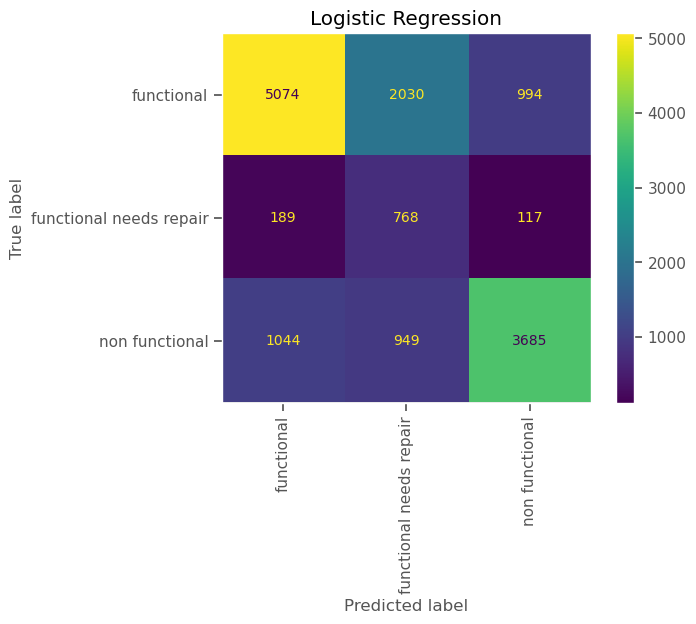

In [230]:
plot_confusion_matrix(lr3, X_test_filt, y_test)
plt.title('Logistic Regression')
plt.xticks(rotation='vertical')
plt.grid();

#### KNN

In [231]:
knn1 = KNeighborsClassifier(3)
knn1.fit(X_train_filt, y_train_res)

KNeighborsClassifier(n_neighbors=3)

In [232]:
# Score on our training data
y_pred = knn1.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.89      0.87      0.88     24161
functional needs repair       0.91      0.96      0.94     24161
         non functional       0.92      0.90      0.91     24161

               accuracy                           0.91     72483
              macro avg       0.91      0.91      0.91     72483
           weighted avg       0.91      0.91      0.91     72483



In [233]:
# Score on our testing data
y_pred = knn1.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.75      0.78      8098
functional needs repair       0.31      0.53      0.39      1074
         non functional       0.77      0.74      0.76      5678

               accuracy                           0.73     14850
              macro avg       0.63      0.67      0.64     14850
           weighted avg       0.76      0.73      0.74     14850



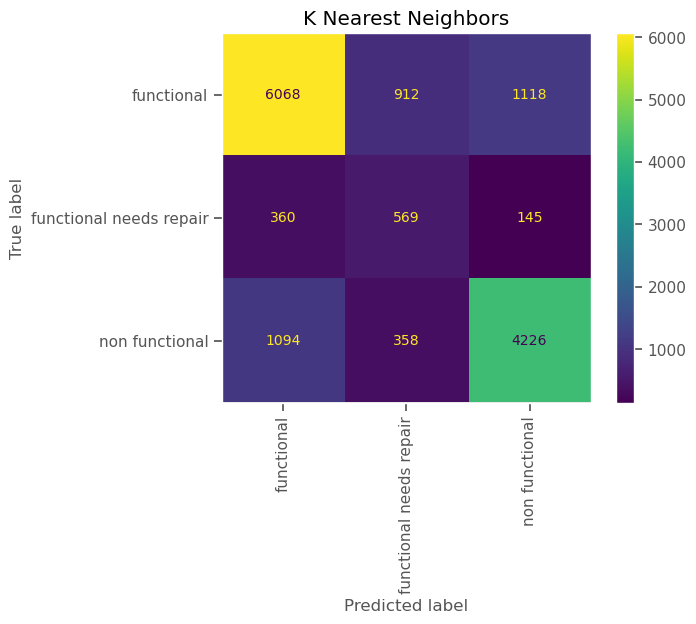

In [234]:
plot_confusion_matrix(knn1, X_test_filt, y_test)
plt.title('K Nearest Neighbors')
plt.xticks(rotation='vertical')
plt.grid();

#### Decision Tree

In [235]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_filt, y_train_res)

DecisionTreeClassifier(random_state=42)

In [236]:
# Score on our training data
y_pred = dt.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       1.00      0.99      0.99     24161
functional needs repair       0.99      1.00      0.99     24161
         non functional       1.00      1.00      1.00     24161

               accuracy                           1.00     72483
              macro avg       1.00      1.00      1.00     72483
           weighted avg       1.00      1.00      1.00     72483



In [237]:
# Score on our testing data
y_pred = dt.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.77      0.79      8098
functional needs repair       0.33      0.46      0.39      1074
         non functional       0.76      0.75      0.76      5678

               accuracy                           0.74     14850
              macro avg       0.63      0.66      0.64     14850
           weighted avg       0.75      0.74      0.75     14850



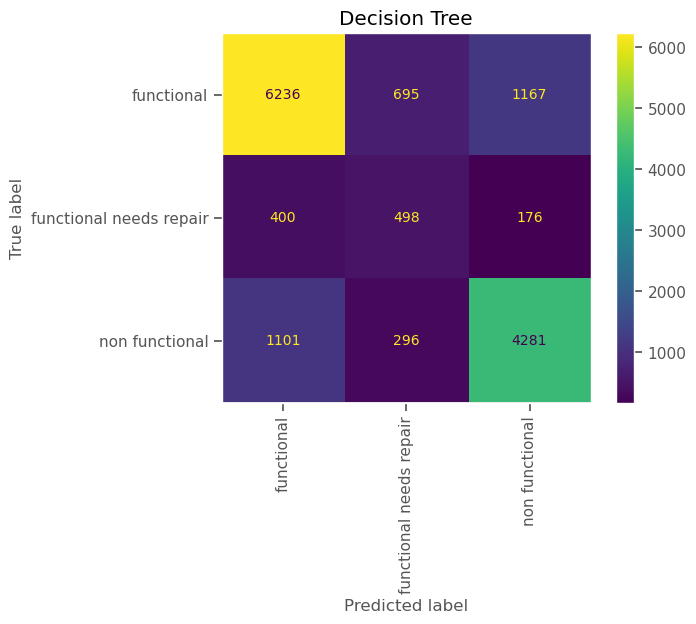

In [238]:
plot_confusion_matrix(dt, X_test_filt, y_test)
plt.title('Decision Tree')
plt.xticks(rotation='vertical')
plt.grid();

#### SVC

In [239]:
# svm = SVC(kernel='linear', decision_function_shape='ovo', random_state=42)
# svm.fit(X_train_filt, y_train_res)

In [240]:
# # Score on our training data
# y_pred = svm.predict(X_train_filt)
# print(classification_report(y_train_res, y_pred))

In [241]:
# # Score on our testing data
# y_pred = svm.predict(X_test_filt)
# print(classification_report(y_test, y_pred))

## Ensemble Methods

Voting and Averaging are "weak" estimators. They are useful in the case that the models are already accurate

#### Voting Ensemble

To explain the idealogy behind voting ensembles, I'll start with an analagy. In a game show like who wants to be a millionare, a contestant can choose to "ask the audience". The contestant usually chooses the answer most voted for by the audience. According to stats from TV studios, the audience chooses the right answer over 90% of the time. This is due to a concept known as "wisdom of the crowds" referring to the collective intelligence of a group being superior to a single expert. Voting Ensembles use wisdom of the crowds to make its prediction based on the mode (or majority prediction) of multiple individual models.


Boosting is another ensemble method based on iterative learning and sequential model building
Light Gradient Boost was Released by Microsoft in 2017
Optimized for parallel and GPU processing.
Useful for big datasets. Uses Regresion trees.

In [242]:
#Base estimators
# lr3 - linear regression model
# knn1 - knn model
# dt - decision tree model
# etc - extra trees classifier model

clf_voting = VotingClassifier(
    estimators = [
        ('linear regression', lr3),
        ('K Nearest Neighbors', knn1),
        ('Decision Tree', dt)])

In [243]:
clf_voting.fit(X_train_filt, y_train_res)

VotingClassifier(estimators=[('linear regression',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('K Nearest Neighbors',
                              KNeighborsClassifier(n_neighbors=3)),
                             ('Decision Tree',
                              DecisionTreeClassifier(random_state=42))])

In [244]:
# Score on our training data
y_pred = clf_voting.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.92      0.93      0.92     24161
functional needs repair       0.94      0.98      0.96     24161
         non functional       0.97      0.92      0.94     24161

               accuracy                           0.94     72483
              macro avg       0.94      0.94      0.94     72483
           weighted avg       0.94      0.94      0.94     72483



In [245]:
# Score on our testing data
y_pred = clf_voting.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.80      0.80      8098
functional needs repair       0.33      0.54      0.41      1074
         non functional       0.82      0.74      0.78      5678

               accuracy                           0.76     14850
              macro avg       0.65      0.69      0.66     14850
           weighted avg       0.78      0.76      0.77     14850



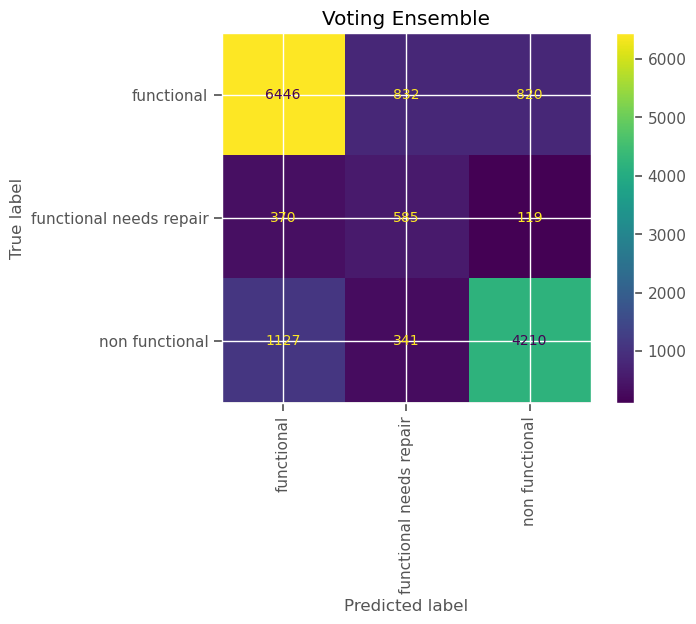

In [246]:
plot_confusion_matrix(clf_voting, X_test_filt, y_test)
plt.title('Voting Ensemble')
plt.xticks(rotation='vertical');

#### Averaging Classifier

In [247]:
#Base estimators
# lr3 - linear regression model
# knn1 - knn model
# dt - decision tree model
# etc - extra trees classifier model

clf_averaging = VotingClassifier(
    estimators = [
        ('linear regression', lr3),
        ('K Nearest Neighbors', knn1),
        ('Decision Tree', dt)],
    voting = 'soft',
)
clf_averaging.fit(X_train_filt, y_train_res)

VotingClassifier(estimators=[('linear regression',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('K Nearest Neighbors',
                              KNeighborsClassifier(n_neighbors=3)),
                             ('Decision Tree',
                              DecisionTreeClassifier(random_state=42))],
                 voting='soft')

In [248]:
# Score on our training data
y_pred = clf_averaging.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.99      0.98      0.98     24161
functional needs repair       0.98      0.99      0.99     24161
         non functional       0.99      0.99      0.99     24161

               accuracy                           0.99     72483
              macro avg       0.99      0.99      0.99     72483
           weighted avg       0.99      0.99      0.99     72483



In [249]:
# Score on our testing data
y_pred = clf_averaging.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.82      0.79      0.80      8098
functional needs repair       0.34      0.52      0.42      1074
         non functional       0.79      0.76      0.78      5678

               accuracy                           0.76     14850
              macro avg       0.65      0.69      0.67     14850
           weighted avg       0.78      0.76      0.77     14850



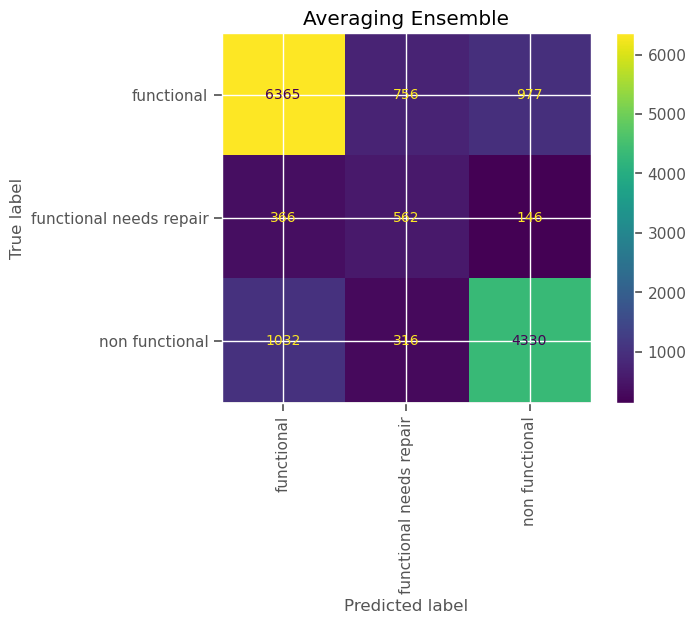

In [250]:
plot_confusion_matrix(clf_averaging, X_test_filt, y_test)
plt.title('Averaging Ensemble')
plt.xticks(rotation='vertical');

#### Extra Trees Classifier

In [251]:
# etc = ExtraTreesClassifier()
# etc.fit(X_train_filt,y_train_res)

In [252]:
# # Score on our training data
# y_pred = etc.predict(X_train_filt)
# print(classification_report(y_train_res, y_pred))

In [253]:
# # Score on our testing data
# y_pred = etc.predict(X_test_filt)
# print(classification_report(y_test, y_pred))

#### Random Forest Classifier

In [286]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_filt,y_train_res)

RandomForestClassifier(random_state=42)

In [287]:
# Score on our training data
y_pred = rfc.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       1.00      0.99      0.99     24161
functional needs repair       0.99      1.00      0.99     24161
         non functional       1.00      1.00      1.00     24161

               accuracy                           1.00     72483
              macro avg       1.00      1.00      1.00     72483
           weighted avg       1.00      1.00      1.00     72483



In [288]:
# Score on our testing data
y_pred = rfc.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.82      0.82      0.82      8098
functional needs repair       0.40      0.50      0.44      1074
         non functional       0.82      0.78      0.80      5678

               accuracy                           0.78     14850
              macro avg       0.68      0.70      0.69     14850
           weighted avg       0.79      0.78      0.79     14850



#### Bagging Classifier Random Forest

Note Bagging is computationally expensive as it uses cross validation and will take time to run

For classification, the optimal value of max_features lies around the square root of the number of features. The square root of 250 is 15.8.

In [257]:
# # Setting max_features to 35 after some trial and error. The square root of number of features didnt seem to work well
# b_rf_clf = BaggingClassifier(RandomForestClassifier(max_depth=26), n_estimators = 30, max_features=35, random_state=42)
# b_rf_clf.fit(X_train_filt,y_train_res)

In [258]:
# # Score on our training data
# y_pred = b_rf_clf.predict(X_train_filt)
# print(classification_report(y_train_res, y_pred))

In [259]:
# # Score on our testing data
# y_pred = b_rf_clf.predict(X_test_filt)
# print(classification_report(y_test, y_pred))

GridSearch on Bagging Classifier

In [260]:
# grid = {"max_samples": [0.5, 1.0],
#         "bootstrap": [True, False],
#         "bootstrap_features": [True, False]}

# b_rf_clf = GridSearchCV(BaggingClassifier(RandomForestClassifier(max_depth=25), n_estimators = 10, max_features = 35),
#                         param_grid = grid)

Do not run the following cells again, takes a very long time and best params are just the default -_-

In [261]:
# b_rf_clf.fit(X_train_filt,y_train_res)

In [262]:
# b_rf_clf.best_params_
# 'bootstrap': True, 'bootstrap_features': False, 'max_samples': 1.0

### Boosting Algorithms
Based on iterative learning and sequential model building.
Good choice when problems are complex, need to apply parallel processing, have big data sets

#### Ada Boost Classifier

In [263]:
# Instantiate an AdaBoostClassifier
# Defaults are estimator=DecisionTree, n_estimator=100, learning_rate = 1
adaboost_clf = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost_clf.fit(X_train_filt, y_train_res)

AdaBoostClassifier(n_estimators=100, random_state=42)

In [264]:
# Score on our training data
y_pred = adaboost_clf.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.65      0.65      0.65     24161
functional needs repair       0.65      0.75      0.70     24161
         non functional       0.74      0.63      0.68     24161

               accuracy                           0.68     72483
              macro avg       0.68      0.68      0.68     72483
           weighted avg       0.68      0.68      0.68     72483



In [265]:
# Score on our testing data
y_pred = adaboost_clf.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.79      0.64      0.71      8098
functional needs repair       0.19      0.65      0.30      1074
         non functional       0.77      0.63      0.69      5678

               accuracy                           0.64     14850
              macro avg       0.58      0.64      0.57     14850
           weighted avg       0.74      0.64      0.67     14850



#### Gradient Boosting Classifier

In [266]:
# Instantiate an GradientBoostingClassifier
# We dont specify an estimator since Gradient Boosting uses regression trees
# Default params: n_estimators=100, learning_rate=0.1, mex_depth=3, min_samples_split, min_samples_leaf, max_features
# In Gradient Boosting, it is recommended to use all the features
gbt_clf = GradientBoostingClassifier(random_state=42)
gbt_clf.fit(X_train_filt, y_train_res)

GradientBoostingClassifier(random_state=42)

In [267]:
# Score on our training data
y_pred = gbt_clf.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.67      0.74      0.70     24161
functional needs repair       0.72      0.79      0.75     24161
         non functional       0.81      0.65      0.72     24161

               accuracy                           0.72     72483
              macro avg       0.73      0.72      0.72     72483
           weighted avg       0.73      0.72      0.72     72483



In [268]:
# Score on our testing data
y_pred = gbt_clf.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.78      0.72      0.75      8098
functional needs repair       0.23      0.62      0.33      1074
         non functional       0.81      0.63      0.71      5678

               accuracy                           0.68     14850
              macro avg       0.61      0.66      0.60     14850
           weighted avg       0.75      0.68      0.70     14850



#### Extreme Gradient Boosting Classifier

Optomized for distributed computing. Parallel training.

In [269]:
xgbc = xgb.XGBClassifier(max_depth=10, random_state=42)
xgbc.fit(X_train_filt,y_train_res)

XGBClassifier(max_depth=10, objective='multi:softprob', random_state=42)

In [270]:
# Score on our training data
y_pred = xgbc.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.83      0.83      0.83     24161
functional needs repair       0.84      0.94      0.88     24161
         non functional       0.92      0.80      0.86     24161

               accuracy                           0.86     72483
              macro avg       0.86      0.86      0.86     72483
           weighted avg       0.86      0.86      0.86     72483



In [271]:
# Score on our testing data
y_pred = xgbc.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.82      0.78      0.80      8098
functional needs repair       0.30      0.61      0.40      1074
         non functional       0.84      0.73      0.78      5678

               accuracy                           0.75     14850
              macro avg       0.65      0.71      0.66     14850
           weighted avg       0.79      0.75      0.76     14850



#### Light Gradient Boosting

Released by Microsoft in 2017
Fast and efficient. Lighter in terms of space.
Optimized for parallel and GPU processing.
Useful for big datasets.

In [272]:
# Params similar to gradient boosting except default max_depth = -1 (unlimited)
clf_lgb = lgb.LGBMClassifier(n_estimators=1000, seed=42)
clf_lgb.fit(X_train_filt,y_train_res)

LGBMClassifier(n_estimators=1000, seed=42)

In [273]:
# Score on our training data
y_pred = clf_lgb.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.90      0.90      0.90     24161
functional needs repair       0.92      0.97      0.94     24161
         non functional       0.95      0.89      0.92     24161

               accuracy                           0.92     72483
              macro avg       0.92      0.92      0.92     72483
           weighted avg       0.92      0.92      0.92     72483



In [274]:
# Score on our testing data
y_pred = clf_lgb.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.83      0.81      0.82      8098
functional needs repair       0.37      0.53      0.44      1074
         non functional       0.82      0.78      0.80      5678

               accuracy                           0.78     14850
              macro avg       0.67      0.71      0.69     14850
           weighted avg       0.79      0.78      0.78     14850



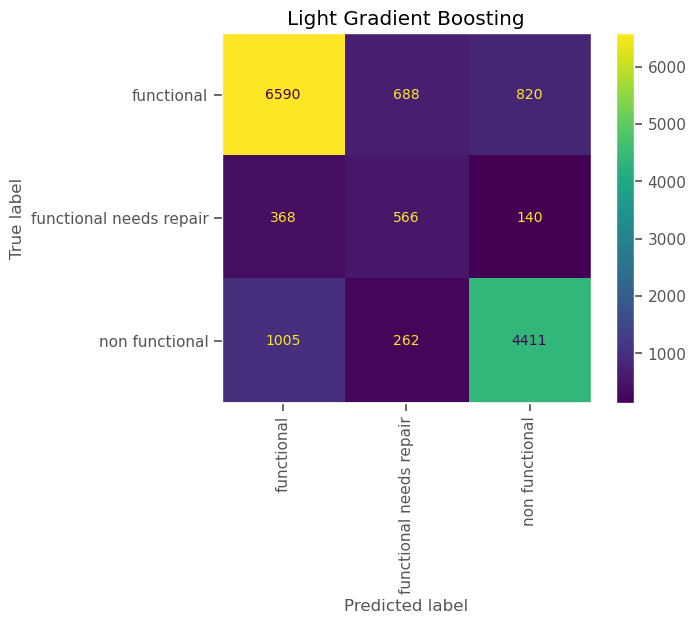

In [275]:
plot_confusion_matrix(clf_lgb, X_test_filt, y_test)
plt.title('Light Gradient Boosting')
plt.xticks(rotation='vertical')
plt.grid();

#### Cat Boost
Open sourced by Yandex(april 2017). Built in handling of categorical features. Accurate and robust. Fast and scalable

In [276]:
# Default Params - n_estimators=1000, learning_rate=0.1, max_depth=3, 
reg_cat = cb.CatBoostClassifier(random_state=500)
reg_cat.fit(X_train_filt, y_train_res)

Learning rate set to 0.098445
0:	learn: 1.0607963	total: 67.2ms	remaining: 1m 7s
1:	learn: 1.0306174	total: 129ms	remaining: 1m 4s
2:	learn: 1.0077049	total: 192ms	remaining: 1m 3s
3:	learn: 0.9874431	total: 261ms	remaining: 1m 5s
4:	learn: 0.9708820	total: 326ms	remaining: 1m 4s
5:	learn: 0.9561074	total: 394ms	remaining: 1m 5s
6:	learn: 0.9425795	total: 457ms	remaining: 1m 4s
7:	learn: 0.9299067	total: 521ms	remaining: 1m 4s
8:	learn: 0.9191888	total: 587ms	remaining: 1m 4s
9:	learn: 0.9099706	total: 648ms	remaining: 1m 4s
10:	learn: 0.9000373	total: 718ms	remaining: 1m 4s
11:	learn: 0.8900699	total: 786ms	remaining: 1m 4s
12:	learn: 0.8825170	total: 854ms	remaining: 1m 4s
13:	learn: 0.8755663	total: 924ms	remaining: 1m 5s
14:	learn: 0.8691129	total: 995ms	remaining: 1m 5s
15:	learn: 0.8626132	total: 1.06s	remaining: 1m 5s
16:	learn: 0.8564400	total: 1.13s	remaining: 1m 5s
17:	learn: 0.8503026	total: 1.19s	remaining: 1m 4s
18:	learn: 0.8445100	total: 1.26s	remaining: 1m 5s
19:	learn:

162:	learn: 0.6285336	total: 10.3s	remaining: 52.9s
163:	learn: 0.6278419	total: 10.4s	remaining: 52.8s
164:	learn: 0.6271913	total: 10.4s	remaining: 52.8s
165:	learn: 0.6265862	total: 10.5s	remaining: 52.7s
166:	learn: 0.6259255	total: 10.5s	remaining: 52.6s
167:	learn: 0.6252799	total: 10.6s	remaining: 52.5s
168:	learn: 0.6245992	total: 10.7s	remaining: 52.4s
169:	learn: 0.6238879	total: 10.7s	remaining: 52.4s
170:	learn: 0.6232115	total: 10.8s	remaining: 52.3s
171:	learn: 0.6226292	total: 10.8s	remaining: 52.2s
172:	learn: 0.6221486	total: 10.9s	remaining: 52.1s
173:	learn: 0.6217920	total: 11s	remaining: 52.1s
174:	learn: 0.6211690	total: 11s	remaining: 52s
175:	learn: 0.6204087	total: 11.1s	remaining: 51.9s
176:	learn: 0.6198750	total: 11.2s	remaining: 51.9s
177:	learn: 0.6193515	total: 11.2s	remaining: 51.8s
178:	learn: 0.6187146	total: 11.3s	remaining: 51.7s
179:	learn: 0.6180154	total: 11.3s	remaining: 51.7s
180:	learn: 0.6172448	total: 11.4s	remaining: 51.6s
181:	learn: 0.6166

321:	learn: 0.5531839	total: 20.3s	remaining: 42.7s
322:	learn: 0.5526782	total: 20.3s	remaining: 42.6s
323:	learn: 0.5522976	total: 20.4s	remaining: 42.5s
324:	learn: 0.5521075	total: 20.4s	remaining: 42.5s
325:	learn: 0.5516298	total: 20.5s	remaining: 42.4s
326:	learn: 0.5514195	total: 20.6s	remaining: 42.3s
327:	learn: 0.5510630	total: 20.6s	remaining: 42.3s
328:	learn: 0.5507965	total: 20.7s	remaining: 42.2s
329:	learn: 0.5503893	total: 20.8s	remaining: 42.1s
330:	learn: 0.5501083	total: 20.8s	remaining: 42.1s
331:	learn: 0.5497090	total: 20.9s	remaining: 42s
332:	learn: 0.5493549	total: 20.9s	remaining: 41.9s
333:	learn: 0.5490618	total: 21s	remaining: 41.9s
334:	learn: 0.5487267	total: 21.1s	remaining: 41.8s
335:	learn: 0.5483986	total: 21.1s	remaining: 41.8s
336:	learn: 0.5480444	total: 21.2s	remaining: 41.7s
337:	learn: 0.5475531	total: 21.3s	remaining: 41.6s
338:	learn: 0.5472459	total: 21.3s	remaining: 41.6s
339:	learn: 0.5468742	total: 21.4s	remaining: 41.5s
340:	learn: 0.54

482:	learn: 0.5094432	total: 30.5s	remaining: 32.6s
483:	learn: 0.5090825	total: 30.5s	remaining: 32.5s
484:	learn: 0.5088952	total: 30.6s	remaining: 32.5s
485:	learn: 0.5087024	total: 30.7s	remaining: 32.4s
486:	learn: 0.5084610	total: 30.7s	remaining: 32.4s
487:	learn: 0.5082548	total: 30.8s	remaining: 32.3s
488:	learn: 0.5081054	total: 30.9s	remaining: 32.2s
489:	learn: 0.5078380	total: 30.9s	remaining: 32.2s
490:	learn: 0.5076838	total: 31s	remaining: 32.1s
491:	learn: 0.5074666	total: 31.1s	remaining: 32.1s
492:	learn: 0.5072717	total: 31.1s	remaining: 32s
493:	learn: 0.5069545	total: 31.2s	remaining: 32s
494:	learn: 0.5067873	total: 31.3s	remaining: 31.9s
495:	learn: 0.5066205	total: 31.3s	remaining: 31.8s
496:	learn: 0.5063596	total: 31.4s	remaining: 31.8s
497:	learn: 0.5061851	total: 31.5s	remaining: 31.7s
498:	learn: 0.5060231	total: 31.5s	remaining: 31.7s
499:	learn: 0.5057613	total: 31.6s	remaining: 31.6s
500:	learn: 0.5055440	total: 31.7s	remaining: 31.5s
501:	learn: 0.5052

642:	learn: 0.4802030	total: 40.9s	remaining: 22.7s
643:	learn: 0.4800727	total: 41s	remaining: 22.7s
644:	learn: 0.4799163	total: 41.1s	remaining: 22.6s
645:	learn: 0.4797277	total: 41.1s	remaining: 22.5s
646:	learn: 0.4795876	total: 41.2s	remaining: 22.5s
647:	learn: 0.4794834	total: 41.3s	remaining: 22.4s
648:	learn: 0.4793148	total: 41.4s	remaining: 22.4s
649:	learn: 0.4791400	total: 41.4s	remaining: 22.3s
650:	learn: 0.4789892	total: 41.5s	remaining: 22.2s
651:	learn: 0.4788222	total: 41.5s	remaining: 22.2s
652:	learn: 0.4786066	total: 41.6s	remaining: 22.1s
653:	learn: 0.4784492	total: 41.7s	remaining: 22s
654:	learn: 0.4783151	total: 41.7s	remaining: 22s
655:	learn: 0.4781406	total: 41.8s	remaining: 21.9s
656:	learn: 0.4779544	total: 41.9s	remaining: 21.9s
657:	learn: 0.4778918	total: 41.9s	remaining: 21.8s
658:	learn: 0.4777785	total: 42s	remaining: 21.7s
659:	learn: 0.4776247	total: 42s	remaining: 21.7s
660:	learn: 0.4775325	total: 42.1s	remaining: 21.6s
661:	learn: 0.4774194	

803:	learn: 0.4582064	total: 51.4s	remaining: 12.5s
804:	learn: 0.4581467	total: 51.5s	remaining: 12.5s
805:	learn: 0.4579702	total: 51.5s	remaining: 12.4s
806:	learn: 0.4578310	total: 51.6s	remaining: 12.3s
807:	learn: 0.4577534	total: 51.6s	remaining: 12.3s
808:	learn: 0.4577244	total: 51.7s	remaining: 12.2s
809:	learn: 0.4575957	total: 51.8s	remaining: 12.1s
810:	learn: 0.4574241	total: 51.8s	remaining: 12.1s
811:	learn: 0.4572742	total: 51.9s	remaining: 12s
812:	learn: 0.4571947	total: 52s	remaining: 12s
813:	learn: 0.4571314	total: 52s	remaining: 11.9s
814:	learn: 0.4570661	total: 52.1s	remaining: 11.8s
815:	learn: 0.4569273	total: 52.1s	remaining: 11.8s
816:	learn: 0.4568545	total: 52.2s	remaining: 11.7s
817:	learn: 0.4568010	total: 52.3s	remaining: 11.6s
818:	learn: 0.4567178	total: 52.3s	remaining: 11.6s
819:	learn: 0.4566027	total: 52.4s	remaining: 11.5s
820:	learn: 0.4565216	total: 52.5s	remaining: 11.4s
821:	learn: 0.4564306	total: 52.5s	remaining: 11.4s
822:	learn: 0.456313

964:	learn: 0.4417672	total: 1m 1s	remaining: 2.24s
965:	learn: 0.4416417	total: 1m 1s	remaining: 2.18s
966:	learn: 0.4415225	total: 1m 1s	remaining: 2.12s
967:	learn: 0.4414506	total: 1m 2s	remaining: 2.05s
968:	learn: 0.4413684	total: 1m 2s	remaining: 1.99s
969:	learn: 0.4412429	total: 1m 2s	remaining: 1.92s
970:	learn: 0.4410968	total: 1m 2s	remaining: 1.86s
971:	learn: 0.4409995	total: 1m 2s	remaining: 1.79s
972:	learn: 0.4409689	total: 1m 2s	remaining: 1.73s
973:	learn: 0.4408634	total: 1m 2s	remaining: 1.67s
974:	learn: 0.4406986	total: 1m 2s	remaining: 1.6s
975:	learn: 0.4405988	total: 1m 2s	remaining: 1.54s
976:	learn: 0.4404950	total: 1m 2s	remaining: 1.47s
977:	learn: 0.4403845	total: 1m 2s	remaining: 1.41s
978:	learn: 0.4403176	total: 1m 2s	remaining: 1.35s
979:	learn: 0.4401162	total: 1m 2s	remaining: 1.28s
980:	learn: 0.4399539	total: 1m 2s	remaining: 1.22s
981:	learn: 0.4398468	total: 1m 2s	remaining: 1.15s
982:	learn: 0.4397388	total: 1m 3s	remaining: 1.09s
983:	learn: 0

In [277]:
# Score on our training data
y_pred = reg_cat.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.81      0.80     24161
functional needs repair       0.84      0.91      0.87     24161
         non functional       0.88      0.79      0.83     24161

               accuracy                           0.84     72483
              macro avg       0.84      0.84      0.84     72483
           weighted avg       0.84      0.84      0.84     72483



In [278]:
# Score on our testing data
y_pred = reg_cat.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.82      0.78      0.80      8098
functional needs repair       0.31      0.59      0.41      1074
         non functional       0.83      0.74      0.78      5678

               accuracy                           0.75     14850
              macro avg       0.65      0.71      0.67     14850
           weighted avg       0.79      0.75      0.77     14850



### Stacking

Combining models together. Good choice when Voting/Averaging dont have great results

In [296]:
# Parameters = classifiers = [clf1, clf2, clf3...], meta_classifiers=clf_meta, use_probas=False, use_features_in_secondary=False

clf_dt = DecisionTreeClassifier(random_state=42)
clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_lr = LogisticRegression(max_iter=1000, random_state=42)


classifiers = [clf_dt, clf_knn, clf_lr, rfc]

clf_meta = reg_cat

clf_stack = StackingClassifier(classifiers, clf_meta, use_features_in_secondary=True)

Target classes need to be numerical for StackingClassifier to work. Use Label Encoder for this

In [297]:
le = LabelEncoder()
le.fit(y_train_res)

LabelEncoder()

In [298]:
y_train_le = le.fit_transform(y_train_res)
y_test_le = le.transform(y_test)

In [299]:
clf_stack.fit(X_train_filt, y_train_le)

Learning rate set to 0.098445
0:	learn: 0.9148188	total: 83.3ms	remaining: 1m 23s
1:	learn: 0.7776978	total: 149ms	remaining: 1m 14s
2:	learn: 0.6701991	total: 214ms	remaining: 1m 11s
3:	learn: 0.5833094	total: 278ms	remaining: 1m 9s
4:	learn: 0.5114931	total: 341ms	remaining: 1m 7s
5:	learn: 0.4513268	total: 404ms	remaining: 1m 6s
6:	learn: 0.4002344	total: 467ms	remaining: 1m 6s
7:	learn: 0.3564513	total: 527ms	remaining: 1m 5s
8:	learn: 0.3184584	total: 589ms	remaining: 1m 4s
9:	learn: 0.2855274	total: 654ms	remaining: 1m 4s
10:	learn: 0.2567956	total: 716ms	remaining: 1m 4s
11:	learn: 0.2315384	total: 779ms	remaining: 1m 4s
12:	learn: 0.2090078	total: 845ms	remaining: 1m 4s
13:	learn: 0.1893958	total: 904ms	remaining: 1m 3s
14:	learn: 0.1716340	total: 969ms	remaining: 1m 3s
15:	learn: 0.1559290	total: 1.04s	remaining: 1m 3s
16:	learn: 0.1418664	total: 1.11s	remaining: 1m 4s
17:	learn: 0.1295401	total: 1.18s	remaining: 1m 4s
18:	learn: 0.1183806	total: 1.24s	remaining: 1m 4s
19:	lea

161:	learn: 0.0139068	total: 10.1s	remaining: 52.5s
162:	learn: 0.0139013	total: 10.2s	remaining: 52.4s
163:	learn: 0.0138899	total: 10.3s	remaining: 52.3s
164:	learn: 0.0138842	total: 10.3s	remaining: 52.3s
165:	learn: 0.0138816	total: 10.4s	remaining: 52.2s
166:	learn: 0.0138794	total: 10.5s	remaining: 52.2s
167:	learn: 0.0138731	total: 10.5s	remaining: 52.1s
168:	learn: 0.0138684	total: 10.6s	remaining: 52s
169:	learn: 0.0138613	total: 10.7s	remaining: 52s
170:	learn: 0.0138587	total: 10.7s	remaining: 51.9s
171:	learn: 0.0138549	total: 10.8s	remaining: 51.8s
172:	learn: 0.0138462	total: 10.8s	remaining: 51.8s
173:	learn: 0.0138422	total: 10.9s	remaining: 51.6s
174:	learn: 0.0138333	total: 10.9s	remaining: 51.6s
175:	learn: 0.0138105	total: 11s	remaining: 51.5s
176:	learn: 0.0137813	total: 11.1s	remaining: 51.4s
177:	learn: 0.0137772	total: 11.1s	remaining: 51.4s
178:	learn: 0.0137722	total: 11.2s	remaining: 51.3s
179:	learn: 0.0137674	total: 11.3s	remaining: 51.3s
180:	learn: 0.0137

322:	learn: 0.0131775	total: 20.1s	remaining: 42.1s
323:	learn: 0.0131755	total: 20.1s	remaining: 42s
324:	learn: 0.0131735	total: 20.2s	remaining: 41.9s
325:	learn: 0.0131713	total: 20.2s	remaining: 41.9s
326:	learn: 0.0131703	total: 20.3s	remaining: 41.8s
327:	learn: 0.0131678	total: 20.4s	remaining: 41.7s
328:	learn: 0.0131660	total: 20.4s	remaining: 41.7s
329:	learn: 0.0131616	total: 20.5s	remaining: 41.6s
330:	learn: 0.0131602	total: 20.6s	remaining: 41.5s
331:	learn: 0.0131593	total: 20.6s	remaining: 41.5s
332:	learn: 0.0131577	total: 20.7s	remaining: 41.4s
333:	learn: 0.0131567	total: 20.7s	remaining: 41.4s
334:	learn: 0.0131553	total: 20.8s	remaining: 41.3s
335:	learn: 0.0131532	total: 20.9s	remaining: 41.2s
336:	learn: 0.0131517	total: 20.9s	remaining: 41.2s
337:	learn: 0.0131505	total: 21s	remaining: 41.1s
338:	learn: 0.0131422	total: 21.1s	remaining: 41.1s
339:	learn: 0.0131360	total: 21.1s	remaining: 41s
340:	learn: 0.0131350	total: 21.2s	remaining: 41s
341:	learn: 0.013133

483:	learn: 0.0128876	total: 30s	remaining: 32s
484:	learn: 0.0128871	total: 30s	remaining: 31.9s
485:	learn: 0.0128851	total: 30.1s	remaining: 31.8s
486:	learn: 0.0128843	total: 30.2s	remaining: 31.8s
487:	learn: 0.0128831	total: 30.2s	remaining: 31.7s
488:	learn: 0.0128825	total: 30.3s	remaining: 31.7s
489:	learn: 0.0128801	total: 30.4s	remaining: 31.6s
490:	learn: 0.0128796	total: 30.4s	remaining: 31.5s
491:	learn: 0.0128785	total: 30.5s	remaining: 31.5s
492:	learn: 0.0128769	total: 30.5s	remaining: 31.4s
493:	learn: 0.0128766	total: 30.6s	remaining: 31.3s
494:	learn: 0.0128755	total: 30.7s	remaining: 31.3s
495:	learn: 0.0128741	total: 30.7s	remaining: 31.2s
496:	learn: 0.0128736	total: 30.8s	remaining: 31.1s
497:	learn: 0.0128722	total: 30.8s	remaining: 31.1s
498:	learn: 0.0128694	total: 30.9s	remaining: 31s
499:	learn: 0.0128683	total: 31s	remaining: 31s
500:	learn: 0.0128674	total: 31s	remaining: 30.9s
501:	learn: 0.0128662	total: 31.1s	remaining: 30.8s
502:	learn: 0.0128653	tota

643:	learn: 0.0127346	total: 40s	remaining: 22.1s
644:	learn: 0.0127336	total: 40.1s	remaining: 22s
645:	learn: 0.0127332	total: 40.1s	remaining: 22s
646:	learn: 0.0127327	total: 40.2s	remaining: 21.9s
647:	learn: 0.0127323	total: 40.2s	remaining: 21.9s
648:	learn: 0.0127320	total: 40.3s	remaining: 21.8s
649:	learn: 0.0127318	total: 40.4s	remaining: 21.7s
650:	learn: 0.0127316	total: 40.4s	remaining: 21.7s
651:	learn: 0.0127298	total: 40.5s	remaining: 21.6s
652:	learn: 0.0127282	total: 40.5s	remaining: 21.5s
653:	learn: 0.0127278	total: 40.6s	remaining: 21.5s
654:	learn: 0.0127275	total: 40.7s	remaining: 21.4s
655:	learn: 0.0127258	total: 40.7s	remaining: 21.4s
656:	learn: 0.0127251	total: 40.8s	remaining: 21.3s
657:	learn: 0.0127239	total: 40.8s	remaining: 21.2s
658:	learn: 0.0127235	total: 40.9s	remaining: 21.2s
659:	learn: 0.0127223	total: 41s	remaining: 21.1s
660:	learn: 0.0127209	total: 41s	remaining: 21s
661:	learn: 0.0127207	total: 41.1s	remaining: 21s
662:	learn: 0.0127203	tota

804:	learn: 0.0126382	total: 50.6s	remaining: 12.3s
805:	learn: 0.0126381	total: 50.7s	remaining: 12.2s
806:	learn: 0.0126369	total: 50.7s	remaining: 12.1s
807:	learn: 0.0126367	total: 50.8s	remaining: 12.1s
808:	learn: 0.0126365	total: 50.8s	remaining: 12s
809:	learn: 0.0126361	total: 50.9s	remaining: 11.9s
810:	learn: 0.0126358	total: 51s	remaining: 11.9s
811:	learn: 0.0126355	total: 51s	remaining: 11.8s
812:	learn: 0.0126346	total: 51.1s	remaining: 11.7s
813:	learn: 0.0126345	total: 51.1s	remaining: 11.7s
814:	learn: 0.0126336	total: 51.2s	remaining: 11.6s
815:	learn: 0.0126335	total: 51.3s	remaining: 11.6s
816:	learn: 0.0126328	total: 51.3s	remaining: 11.5s
817:	learn: 0.0126324	total: 51.4s	remaining: 11.4s
818:	learn: 0.0126320	total: 51.5s	remaining: 11.4s
819:	learn: 0.0126318	total: 51.5s	remaining: 11.3s
820:	learn: 0.0126313	total: 51.6s	remaining: 11.2s
821:	learn: 0.0126311	total: 51.6s	remaining: 11.2s
822:	learn: 0.0126307	total: 51.7s	remaining: 11.1s
823:	learn: 0.0126

965:	learn: 0.0125701	total: 1m	remaining: 2.13s
966:	learn: 0.0125699	total: 1m	remaining: 2.07s
967:	learn: 0.0125689	total: 1m	remaining: 2.01s
968:	learn: 0.0125687	total: 1m	remaining: 1.94s
969:	learn: 0.0125682	total: 1m	remaining: 1.88s
970:	learn: 0.0125680	total: 1m	remaining: 1.82s
971:	learn: 0.0125678	total: 1m	remaining: 1.76s
972:	learn: 0.0125676	total: 1m 1s	remaining: 1.69s
973:	learn: 0.0125672	total: 1m 1s	remaining: 1.63s
974:	learn: 0.0125666	total: 1m 1s	remaining: 1.57s
975:	learn: 0.0125664	total: 1m 1s	remaining: 1.51s
976:	learn: 0.0125657	total: 1m 1s	remaining: 1.44s
977:	learn: 0.0125647	total: 1m 1s	remaining: 1.38s
978:	learn: 0.0125646	total: 1m 1s	remaining: 1.32s
979:	learn: 0.0125641	total: 1m 1s	remaining: 1.25s
980:	learn: 0.0125634	total: 1m 1s	remaining: 1.19s
981:	learn: 0.0125629	total: 1m 1s	remaining: 1.13s
982:	learn: 0.0125627	total: 1m 1s	remaining: 1.07s
983:	learn: 0.0125625	total: 1m 1s	remaining: 1s
984:	learn: 0.0125621	total: 1m 1s	r

StackingClassifier(classifiers=[DecisionTreeClassifier(random_state=42),
                                KNeighborsClassifier(),
                                LogisticRegression(max_iter=1000,
                                                   random_state=42),
                                RandomForestClassifier(random_state=42)],
                   meta_classifier=<catboost.core.CatBoostClassifier object at 0x000001A147249CF8>,
                   use_features_in_secondary=True)

In [300]:
# Score on our training data
y_pred = clf_stack.predict(X_train_filt)
print(classification_report(y_train_le, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     24161
           1       0.99      1.00      0.99     24161
           2       1.00      1.00      1.00     24161

    accuracy                           1.00     72483
   macro avg       1.00      1.00      1.00     72483
weighted avg       1.00      1.00      1.00     72483



In [301]:
# Score on our testing data
y_pred = clf_stack.predict(X_test_filt)
print(classification_report(y_test_le, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.76      0.79      8098
           1       0.25      0.53      0.34      1074
           2       0.83      0.77      0.80      5678

    accuracy                           0.74     14850
   macro avg       0.64      0.68      0.64     14850
weighted avg       0.79      0.74      0.76     14850



In [295]:
confusion_matrix(y_test_le, y_pred)

array([[6270, 1244,  584],
       [ 415,  558,  101],
       [1190,  428, 4060]], dtype=int64)

#### Where to go from here

those columns with the null values

tuning hyper parameters